# Prediction Module

    The main goal of the prediction module is to use the PropaPhenKG+ and the observations found in the detection module to cluster the observations into similar phenomenon clusters

In [350]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Libraries

### Installing

In [351]:
#!pip install pandas
#!pip install tqdm
#!pip install -U scikit-learn
#!pip install matplotlib

### Standard

In [352]:
import pandas as pd
import numpy as np
from tqdm import tqdm
import glob

### Custom libraries

## Globals

In [353]:
path_to_kb_gazetteer = "../Detection/data/gazetteers/kbgazetteer.csv"
path_to_netwoork_gazetteer = "../Detection/data/gazetteers/world_gazetteer.csv"
path_to_observationcsv = "../Detection/data/csv/observations_phrase.csv"
path_to_worldkg_nodes = "../Description/data/worldkg_nodes.csv"

In [354]:
path_to_covid_journalobservationcsv = "../data/neo4j/covid_observations_journal.csv"
path_to_covid_medicalobservationcsv = "../data/neo4j/covid_observations_medical.csv"
path_to_covid_socialobservationcsv = "../data/neo4j/covid_observations_social.csv"
path_to_monkeypox_journalobservationcsv = "../data/neo4j/monkeypox_observations_journal.csv"
path_to_monkeypox_medicalobservationcsv = "../data/neo4j/monkeypox_observations_medical.csv"
path_to_monkeypox_socialobservationcsv = "../data/neo4j/monkeypox_observations_social.csv"

## Observation Embedding

    It should get the observations and the PropaPhenKG+ to transform the observations into observation vectors

### Loading Observations

In [355]:
df_covid_observations_journal = pd.read_csv(path_to_covid_journalobservationcsv)
df_covid_observations_medical = pd.read_csv(path_to_covid_medicalobservationcsv)
df_covid_observations_social = pd.read_csv(path_to_covid_socialobservationcsv)
df_covid_observations_journal['System_Name'] = 'Journal_COVID_' + df_covid_observations_journal['System_Name'].astype(str)
df_covid_observations_medical['System_Name'] = 'Medical_COVID_' + df_covid_observations_medical['System_Name'].astype(str)
df_covid_observations_social['System_Name'] = 'Social_COVID_' + df_covid_observations_social['System_Name'].astype(str)
df_covid_observations = pd.concat([df_covid_observations_journal,df_covid_observations_medical], ignore_index=True)
df_covid_observations = pd.concat([df_covid_observations,df_covid_observations_social], ignore_index=True)

In [356]:
df_monkeypox_observations_journal = pd.read_csv(path_to_monkeypox_journalobservationcsv)
df_monkeypox_observations_medical = pd.read_csv(path_to_monkeypox_medicalobservationcsv)
df_monkeypox_observations_social = pd.read_csv(path_to_monkeypox_socialobservationcsv)
df_monkeypox_observations_journal['System_Name'] = 'Journal_Monkeypox_' + df_monkeypox_observations_journal['System_Name'].astype(str)
df_monkeypox_observations_medical['System_Name'] = 'Medical_Monkeypox_' + df_monkeypox_observations_medical['System_Name'].astype(str)
df_monkeypox_observations_social['System_Name'] = 'Social_Monkeypox_' + df_monkeypox_observations_social['System_Name'].astype(str)
df_monkeypox_observations = pd.concat([df_monkeypox_observations_journal,df_monkeypox_observations_medical], ignore_index=True)
df_monkeypox_observations = pd.concat([df_monkeypox_observations,df_monkeypox_observations_social], ignore_index=True)

In [357]:
def obsToList(obs,isint=False):
    newlist = list([x.replace("'",'') for x in
        map(str.strip, obs.strip('][').replace('"', '').replace('"', "").split(','))])
    if isint:
        return [int(x) for x in newlist]
    else:
        return newlist

In [358]:
def getTopMax(df_observations, top=10):    
    for index, row in df_observations.iterrows():
        newsort_value = []
        newsort_names = []
        newsort_id = []
        for (x,y,z) in zip( obsToList(row['c.id']),obsToList(row['intensity'],True),obsToList(row['c.name'])):
            if z not in newsort_names:
                newsort_names.append(z)
                newsort_value.append(y)
                newsort_id.append(x)
        newsort_names = [x for _, x in sorted(zip(newsort_value, newsort_names ))]
        newsort_id = [x for _, x in sorted(zip(newsort_value, newsort_id ))]
        newsort_value.sort()
        df_observations.at[index,'c.id'] = str(newsort_id[-min(top,len(newsort_id)):])
        df_observations.at[index,'intensity'] = str(newsort_value[-min(top,len(newsort_id)):])
        df_observations.at[index,'c.name'] = str(newsort_names[-min(top,len(newsort_id)):])
    return df_observations

In [359]:
df_covid_observations = getTopMax(df_covid_observations,top=25)
df_monkeypox_observations = getTopMax(df_monkeypox_observations,top=25)

In [360]:
df_observations = pd.concat([df_covid_observations,df_monkeypox_observations], ignore_index=True)

In [361]:
obs_dict = {}
obs_set = set([])
for index, row in df_observations.iterrows():
    obs_dict[row['System_Name']] = obsToList(row['c.name'])
    obs_set = obs_set.union(set(obs_dict[row['System_Name']]))
place_set = list(obs_dict.keys())

### Embeddings

In [362]:
class ObservationEmbedding():
    
    def __init__(self, obs_dict):
        self.obs_dict = obs_dict
        
    def binaryDictionaryEmbedding(self, dict_kb):
        obs_matrix = np.zeros((len(obs_dict.keys()),len(dict_kb)))
        for system in self.obs_dict.keys():
            for kb_item in obs_dict[system]:
                obs_matrix[dict_net[system],dict_kb[kb_item]] = 1
        return obs_matrix

In [363]:
dict_kb = dict(zip(list(obs_set),range(len(obs_set))))

In [364]:
dict_net = dict(zip(list(df_observations['System_Name']),range(len(place_set))))

In [365]:
#import sys
#print("The size of the variable is:",sys.getsizeof(obs_matrix), "bytes.")

In [366]:
obsEmbedding = ObservationEmbedding(obs_dict)

In [367]:
embeddingMatrix = obsEmbedding.binaryDictionaryEmbedding(dict_kb)

### Connection to Neo4j

## Observation Clustering
    It should get the observation vectors and transform them into Phenomenon Cluster

In [368]:
class ObservationClustering():
    
    def __init__(self, embeddingMatrix=None):
        self.embeddingMatrix = embeddingMatrix
        
    def KMeans(self,nb_clusters,random_state=0,n_init="auto"):
        return KMeans(n_clusters=nb_clusters, random_state=random_state, n_init=n_init).fit(self.embeddingMatrix)
    
    def plot(self, legend_list, labels, apply_pca=False,apply_tsne=True, pca_random_state=1):
        if apply_pca:
            pca = PCA(2, random_state=pca_random_state)
            matrix = pca.fit_transform(self.embeddingMatrix)
        elif apply_tsne:
            tsne = TSNE(n_components=2, random_state=pca_random_state)
            matrix = tsne.fit_transform(self.embeddingMatrix)
        else:
            matrix = self.embeddingMatrix
        u_labels = np.unique(labels)
        for i in u_labels:
            plt.scatter(matrix[labels == i , 0] , matrix[labels == i , 1] , label = i)
        # Label points
        for (i,j, legend) in zip(matrix[:,0], matrix[:,1],legend_list):
            plt.text(i, j, legend)
        plt.legend()
        plt.show()
    
    def smartPrint(self, np_obslist, labels):
        u_labels = np.unique(labels)
        print('Clusters:')
        for i in range(len(u_labels)):
            print("clusters : " + str(u_labels[i]))
            print(np_obslist[labels==u_labels[i]])

In [369]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

In [370]:
embeddingMatrix.shape

(126, 371)

In [371]:
list_indexes = list(range(embeddingMatrix.shape[0]))# ALL LIST
#list_indexes = [0,5,27,1,15,33] # BEST LIST
#list_indexes = [0,5,27,67,78,125] # Both propagations

In [372]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
matrix = tsne.fit_transform(embeddingMatrix)
obsClusteringModule = ObservationClustering(matrix[list_indexes])

In [373]:
kmeans = obsClusteringModule.KMeans(2,random_state=9)

In [374]:
list_type = []
for index, row in df_observations.iterrows():
    if "COVID" in row["System_Name"]:
        list_type.append(0)
    else:
        list_type.append(1)

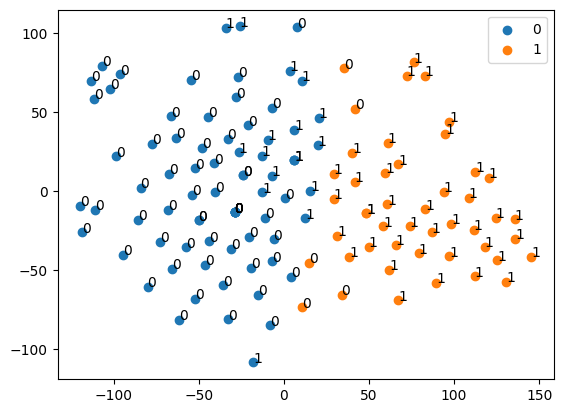

In [375]:
obsClusteringModule.plot(np.array(list_type),kmeans.labels_,
                         apply_tsne=False )

In [376]:
from sklearn.metrics import f1_score,classification_report
print(classification_report(list_type, kmeans.labels_))

              precision    recall  f1-score   support

           0       0.77      0.92      0.84        66
           1       0.89      0.70      0.79        60

    accuracy                           0.82       126
   macro avg       0.83      0.81      0.81       126
weighted avg       0.83      0.82      0.81       126



In [377]:
f1_score(list_type, kmeans.labels_, labels=[0,1])

0.7850467289719626

## Neo4j Theta Evaluation

In [378]:
import sys
sys.path.append('../Detection/')
from lib.kgce.schema.semantic.neo4jclasses import Neo4jRelation
from lib.kgce.neo4j.handler import Neo4jWrapper

In [379]:
from neo4j import GraphDatabase
from tqdm import tqdm


class Neo4jWrapper:

    def __init__(self, uri, userName, password):
        self.uri = uri
        self.userName = userName
        self.password = password
        # Connect to the neo4j database server
        self.graphDB_Driver  = GraphDatabase.driver(uri, auth=(userName, password)) 
        
    def sendQuery(self, cql_commands):
        result = []
        done_queries = []
        with self.graphDB_Driver.session() as graphDB_Session:
            for cqlCreate in tqdm(cql_commands):
                try:
                    result += [graphDB_Session.run(cqlCreate).to_df()]
                    done_queries.append(cqlCreate)
                except Exception as e:
                    tqdm.write(str(e))
                    tqdm.write(cqlCreate)
                    result += [str(e)]
        return result
    
    def closeConnection(self):
        self.graphDB_Driver.close()

In [380]:
def getTrueIndexes(phenomenonSourceName, date):
    jm = df_observations[
    df_observations['System_Name'].str.contains(phenomenonSourceName)]
    jm = jm[jm["n.id"].isin(df_result[df_result["Date"]==date]['Country'].tolist())]
    return jm.index.tolist()

In [382]:
neowrapper = Neo4jWrapper(uri="bolt://localhost:7687",userName="neo4j",password="test")

In [383]:
strQuery = """MATCH (b:CUI)-[r:isReported]->(c:Country) WHERE b.id = "C0276180" return c.id as Country, r.date as Date;"""
result = neowrapper.sendQuery([strQuery])
df_result = result[0]
df_result["Date"] = df_result["Date"].apply(lambda x: x[:7].lower())
df_result = df_result.drop_duplicates()

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:01<00:00,  1.25s/it]


In [384]:
monkeyindex = getTrueIndexes('Journal_Monkeypox','2022-05') + getTrueIndexes('Medical_Monkeypox','2022-06') + getTrueIndexes('Social_Monkeypox','2022-05')

In [385]:
strQueryChinaNov = """
CREATE (b:CUI{id:"C5203670"})-[r:isReported]->(c:Country{id:'wkg:424313582'})
SET r.Date_reported = "2019-11"
RETURN r
"""
strQueryChinaDec = """
CREATE (b:CUI{id:"C5203670"})-[r:isReported]->(c:Country{id:'wkg:424313582'})
SET r.Date_reported = "2019-12"
RETURN r
"""
result = neowrapper.sendQuery([strQueryChinaNov,strQueryChinaDec])

100%|█████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 31.47it/s]


In [386]:
strQuery = """MATCH (b:CUI)-[r:isReported]->(c:Country) WHERE b.id = "C5203670" return c.id as Country, r.Date_reported as Date;"""
result = neowrapper.sendQuery([strQuery])
df_result = result[0]
df_result["Date"] = df_result["Date"].apply(lambda x: x[:7].lower())
df_result = df_result.drop_duplicates()

100%|█████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.28it/s]


In [387]:
covidindex = getTrueIndexes('Journal_COVID','2019-11') + getTrueIndexes('Medical_COVID','2019-12') + getTrueIndexes('Social_COVID','2020-02')

In [388]:
list_indexes = monkeyindex + covidindex

In [389]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=42)
matrix = tsne.fit_transform(embeddingMatrix)
obsClusteringModule = ObservationClustering(matrix[list_indexes])

In [390]:
kmeans = obsClusteringModule.KMeans(2,random_state=9)

In [391]:
list_type = []
for index, row in df_observations.iterrows():
    if index in monkeyindex:
        list_type.append(0)
    elif index in covidindex:
        list_type.append(1)

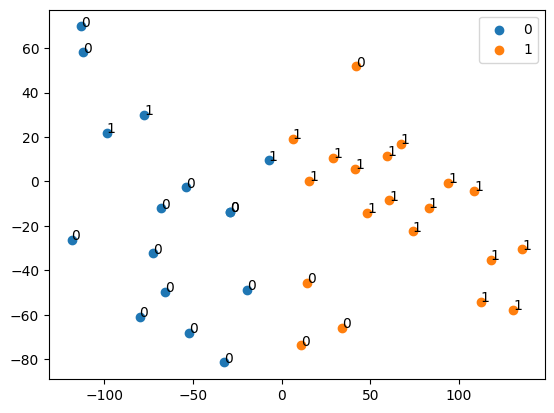

In [392]:
obsClusteringModule.plot(np.array(list_type),kmeans.labels_,
                         apply_tsne=False )

In [393]:
from sklearn.metrics import f1_score
print(classification_report(list_type, kmeans.labels_))

              precision    recall  f1-score   support

           0       0.81      0.76      0.79        17
           1       0.80      0.84      0.82        19

    accuracy                           0.81        36
   macro avg       0.81      0.80      0.80        36
weighted avg       0.81      0.81      0.81        36



In [394]:
from sklearn.metrics import f1_score
f1_score(list_type, kmeans.labels_)

0.8205128205128205

In [395]:
covidindex

[0, 5, 18, 20, 22, 24, 28, 32, 37, 38, 39, 41, 46, 51, 55, 56, 57, 62, 65]

In [396]:
list_str = []
for index, row in df_observations.iterrows():
    if 'COVID' in row['System_Name']:
        list_str.append('COVID-Dataset')
    elif 'Monkeypox' in row['System_Name']:
        list_str.append('Monkeypox-Dataset')

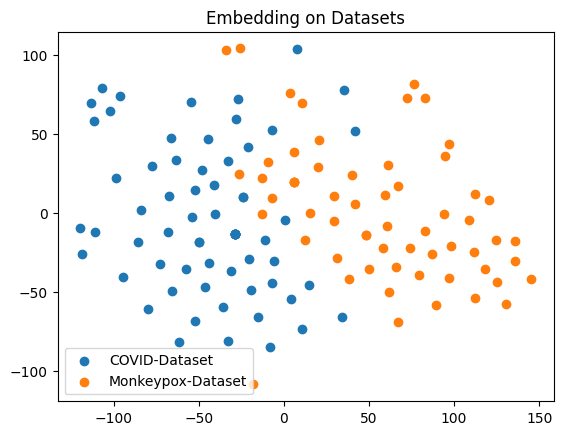

In [397]:
# Label points
for i in np.unique(np.array(list_str)):
    plt.scatter(matrix[np.array(list_str) == i , 0] , matrix[np.array(list_str) == i , 1] , label = i)
plt.title('Embedding on Datasets')
plt.legend()
plt.show()

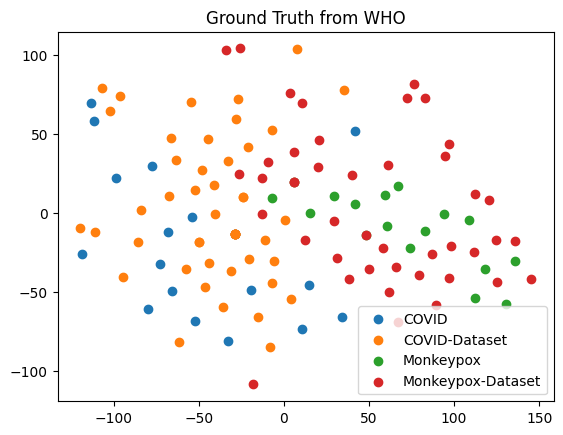

In [398]:
list_str = []
for index, row in df_observations.iterrows():
    if index in monkeyindex:
        list_str.append('Monkeypox')
    elif index in covidindex:
        list_str.append('COVID')
    elif 'COVID' in row['System_Name']:
        list_str.append('COVID-Dataset')
    elif 'Monkeypox' in row['System_Name']:
        list_str.append('Monkeypox-Dataset')
# Label points
for i in np.unique(np.array(list_str)):
    plt.scatter(matrix[np.array(list_str) == i , 0] , matrix[np.array(list_str) == i , 1] , label = i)
plt.title('Ground Truth from WHO')
plt.legend()
plt.show()

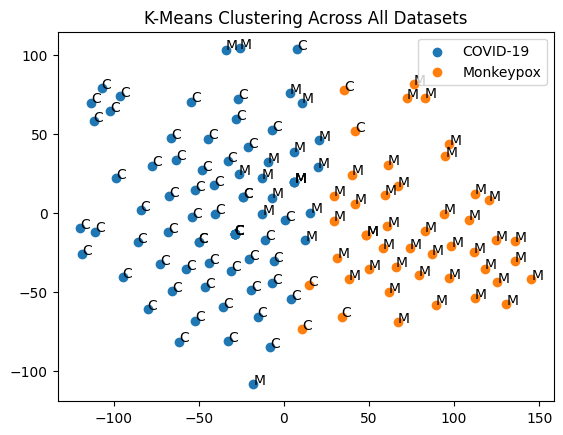

In [399]:
list_indexes = list(range(embeddingMatrix.shape[0]))
tsne = TSNE(n_components=2, random_state=42)
matrix = tsne.fit_transform(embeddingMatrix)
obsClusteringModule = ObservationClustering(matrix[list_indexes])
kmeans = obsClusteringModule.KMeans(2,random_state=9)
list_type = []
for index, row in df_observations.iterrows():
    if 'COVID' in row['System_Name']:
        list_type.append('C')
    elif 'Monkeypox' in row['System_Name']:
        list_type.append('M')
# Label points
array_labels = np.array(kmeans.labels_)
for i in np.unique(array_labels):
    label = 'COVID-19'
    if i == 1:
        label = 'Monkeypox'
    plt.scatter(matrix[array_labels == i , 0] , matrix[array_labels == i , 1] , label = label)
for (i,j, legend) in zip(matrix[:,0], matrix[:,1],list_type):
            plt.text(i, j, legend)
plt.title('K-Means Clustering Across All Datasets')
plt.legend()
plt.show()

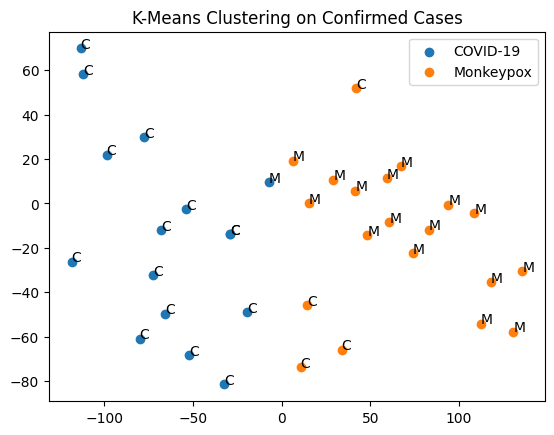

In [400]:
list_indexes = monkeyindex + covidindex
tsne = TSNE(n_components=2, random_state=42)
matrix = tsne.fit_transform(embeddingMatrix)
matrix = matrix[list_indexes]
obsClusteringModule = ObservationClustering(matrix)
kmeans = obsClusteringModule.KMeans(2,random_state=9)
list_type = []
for index in list_indexes:
    if index in monkeyindex:
        list_type.append('M')
    elif index in covidindex:
        list_type.append('C')
# Label points
array_labels = np.array(kmeans.labels_)
for i in np.unique(array_labels):
    label =  'COVID-19'
    if i == 1:
        label = 'Monkeypox'
    plt.scatter(matrix[array_labels == i , 0] , matrix[array_labels == i , 1] , label = label)
for (i,j, legend) in zip(matrix[:,0], matrix[:,1],list_type):
            plt.text(i, j, legend)
plt.title('K-Means Clustering on Confirmed Cases')
plt.legend()
plt.show()

In [401]:
truth = np.array(list_type)
truth[truth=='C'] = 0
truth[truth=='M'] = 1
truth = truth.astype(int)

In [402]:
from sklearn.metrics import f1_score
print(classification_report(truth, kmeans.labels_))

              precision    recall  f1-score   support

           0       0.94      0.79      0.86        19
           1       0.80      0.94      0.86        17

    accuracy                           0.86        36
   macro avg       0.87      0.87      0.86        36
weighted avg       0.87      0.86      0.86        36



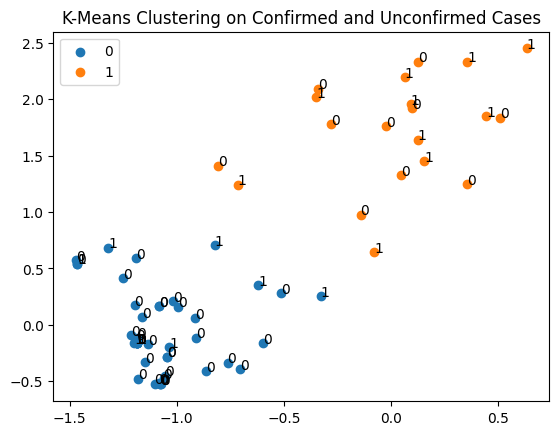

In [403]:
list_indexes = list(range(df_covid_observations.shape[0]))
tsne = PCA(2, random_state=1)
matrix = tsne.fit_transform(embeddingMatrix)
matrix = matrix[list_indexes]
obsClusteringModule = ObservationClustering(matrix)
kmeans = obsClusteringModule.KMeans(2,random_state=9)
list_type = []
for index, row in df_observations.iloc[list_indexes].iterrows():
    if index in covidindex:
        list_type.append(1)
    else:
        list_type.append(0)
# Label points
array_labels = np.array(kmeans.labels_)
for i in np.unique(array_labels):
    plt.scatter(matrix[array_labels == i , 0] , matrix[array_labels == i , 1] , label = i)
for (i,j, legend) in zip(matrix[:,0], matrix[:,1],list_type):
            plt.text(i, j, legend)
plt.title('K-Means Clustering on Confirmed and Unconfirmed Cases')
plt.legend()
plt.show()

In [404]:
from sklearn.metrics import f1_score
print(classification_report(np.array(list_type), kmeans.labels_))

              precision    recall  f1-score   support

           0       0.80      0.79      0.80        47
           1       0.50      0.53      0.51        19

    accuracy                           0.71        66
   macro avg       0.65      0.66      0.65        66
weighted avg       0.72      0.71      0.71        66

